In [1]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace

In [185]:
class BaseRiotModel:
    def __init__(self, compartments=["Potential Protestors", "Peaceful Protestors", "Violent Protestors", "Law Enforcement", "Removed"], **kwargs):

        required_arguments = ["t0", "tf", "resolution", 'city_pop', "init_protestors", "init_violent", "init_law_enf",
                              "init_removals", "total_law_enf", "alpha_0", "alpha_1", "beta_0", "beta_1"]
        for arg in required_arguments:
            if arg not in kwargs.keys():
                raise AttributeError(f"Required Parameter Not Included: {arg}")
            
        self.compartments = {name: i for i, name in enumerate(compartments)}
        for k, v in kwargs.items():
            setattr(self, k, v)

        self.t = np.linspace(self.t0, self.tf, self.resolution)
        self.y0 = self.create_initial_conditions()

    # define the initial condition
    def create_initial_conditions(self):

        init_S = (self.city_pop - (self.init_protestors + self.init_violent + self.init_law_enf + self.init_removals)) / self.city_pop
        init_P = self.init_protestors / self.city_pop
        init_V = self.init_violent / self.city_pop
        init_L = self.init_law_enf / self.city_pop
        init_R =  self.init_removals / self.city_pop
        y0 = np.array([init_S, init_P, init_V, init_L, init_R])
        return y0
    
    def ode(self, t, x):
        S, P, V, L, R = x
        dS_dt = -self.alpha_0 * S * P - self.alpha_1 * S * V
        dP_dt = self.alpha_0 * S * P - self.beta_0 * P - self.beta_1 * P * V
        dV_dt = self.alpha_1 * S * V + self.beta_1 * P * V - self.phi * V * L
        dL_dt = self.eps * V * L
        dR_dt = self.beta_0 * P + self.phi * V * L
        return np.array([dS_dt, dP_dt, dV_dt, dL_dt, dR_dt])
        
    def solve(self):
        system = self.ode
        sol = solve_ivp(system, (self.t0, self.tf), self.y0, t_eval=self.t)
        return sol
    
    def plot(self, sol, compartments=None, title="SIR Model Riot Development"):
        if compartments is None:
            compartments=self.compartments.keys()

        plt.figure(figsize=(7, 4))
        for name in compartments:
            if name not in self.compartments.keys():
                raise ValueError(f"Trying to plot nonexistent compartment: {name}")
            i = self.compartments[name]
            plt.plot(sol.t, sol.y[i] * self.city_pop, label=name)
            
        plt.xlabel("Hours")
        plt.ylabel("Number Individuals")
        plt.title(title)
        plt.legend(loc="upper right")
        plt.show()

In [218]:
init_pop = {
    "city_pop": 1000,
    "init_protestors": 20,
    "init_violent": 1,
    "init_law_enf": 3,
    "init_removals": 0,
    "total_law_enf": 200
}

infection_rates = {
    "alpha_0": 1,
    "alpha_1": 0.1,
    "beta_0": 0.1,
    "beta_1": 1,
}

law_enforcement_params = {
    "phi": 5,
    "eps": 1,
}

params = init_pop | infection_rates | law_enforcement_params


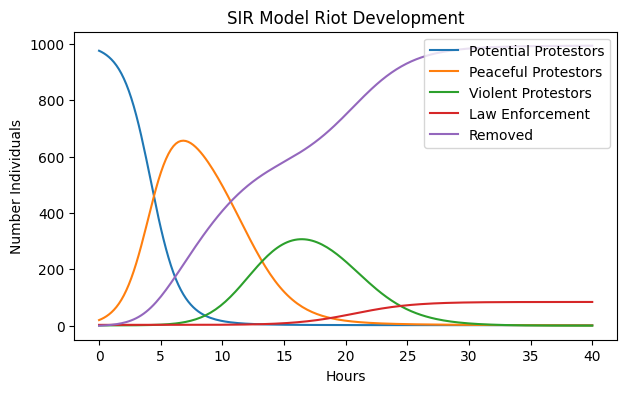

In [220]:
riot = BaseRiotModel(t0=0, tf=40, resolution=200, **params)
sol = riot.solve()
riot.plot(sol)